In [ ]:
import pandas as pd
import torch
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/'

# DRIVE_DATASET_PATH = '/content/gdrive/Shareddrives/SpartanGPT'

'02 copy.jpg'
'107-Aspirevision Tech Education Pvt.pdf'
 1226.pdf
'2(1).jpg'
'3(1).jpg'
'3. An Informal Introduction to Python — Python 2.7.pdf'
'4(1).jpg'
 4893XXXXXXXXXX29_19-11-2019.PDF
'5(1).jpg'
'5. Data Structures — Python 2.7.pdf'
'6(1).jpg'
'6. Modules — Python 2.7.pdf'
'7(1).jpg'
'7. Input and Output — Python 2.7.pdf'
 Arrays.pdf
'Boarding Pass.pdf'
'CamScanner 12-29-2021 16.06.gdoc'
'CamScanner 12-29-2021 16.06.pdf'
 Cert14252953215.pdf
 Cert3688523137.pdf
'certificate New Doc 2017-08-21 - Page 1.pdf'
'certiNew Doc 2017-08-21 - Page 2.pdf'
'c multiple choice questions and answers pdf.pdf'
'Colab Notebooks'
'Command line argument.pptx'
 complete_pf_withdrawal_online_process.zip
 Concepts_introduction.pptx
'C - Programming.pptx'
'C Programming - Summer PrePlacement Training.pdf'
'C Programming Test_1_Answers.pptx'
 data.csv
'data_defination (1).csv'
 dataset_airbnb-scraper_2022-10-21_03-38-04-881.json
 dbms_hw5.drawio
 DL_presentation.docx
'Document from mounica'
'Document from

In [ ]:
import json
filepath = '/content/drive/MyDrive/output_final_allfiles.json'
with open(filepath, 'r') as f:
    sjsu_prompts_json = json.load(f)

In [ ]:
data_list = sjsu_prompts_json["data"]
sjsu_data = pd.DataFrame(data_list )
sjsu_data.rename(columns={'prompt': 'question', 'completion': 'answer'}, inplace=True)


In [ ]:
sjsu_data

,question,answer
0,When will the accounting advancement center ho...,"march 13 and 14, 2023"
1,"Who hosted the April 19, 2023 event?",accounting advancement center
2,In what season of 2023 will the accounting adv...,fall
3,Where can you find up to date news and events?,sjsu tax institute
4,What department has numerous scholarships avai...,department of accounting and finance
...,...,...
8923,How many courses are available at san jose sta...,the opportunities are only limited by your ima...
8924,Who may take courses at sjsu?,"former san jose state university students, sjs..."
8925,How many units of credit can an open universit...,24 units to an undergraduate degree or 9 units...
8926,Who is not eligible to enroll through open uni...,currently-enrolled (admitted) sjsu students or...


In [ ]:
print(sjsu_data['answer'].isnull().sum())

0


In [ ]:
!pip install sentencepiece
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 123.2 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
class SJSUDataset(Dataset):
    def __init__(self, data, tokenizer, source_max_length, target_max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.source_max_length = source_max_length
        self.target_max_length = target_max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        source_encoding = tokenizer(row['question'], truncation=True,
                                    max_length=self.source_max_length, padding='max_length', return_tensors='pt')
        target_encoding = tokenizer(row['answer'], truncation=True,
                                    max_length=self.target_max_length, padding='max_length', return_tensors='pt')

        labels = target_encoding['input_ids']
        labels[labels == 0] = -100  # We set padding tokens to -100, so they don't affect the loss

        return dict(
            question=row['question'],
            answer=row['answer'],
            input_ids=source_encoding['input_ids'].flatten(),
            attention_mask=source_encoding['attention_mask'].flatten(),
            labels=labels.flatten()
        )


In [ ]:


# Assuming your DataFrame is called df
train_df, val_df = train_test_split(sjsu_data, test_size=0.2, random_state=42)

print(f'Training samples: {len(train_df)}')
print(f'Validation samples: {len(val_df)}')

Training samples: 7142
Validation samples: 1786


In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base', model_max_length=512)

# Assuming you have your data in a pandas DataFrame called df, and you've split it into train_df and val_df
train_dataset = SJSUDataset(train_df, tokenizer, source_max_length=128, target_max_length=128)
val_dataset = SJSUDataset(val_df, tokenizer, source_max_length=128, target_max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=16)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('t5-base')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

total_steps = len(train_dataloader) * 20  # Number of training epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Initialize early stopping variables
best_val_loss = float('inf')
early_stopping_patience = 3
patience_counter = 0

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
for epoch in range(20):  # Number of training epochs
    total_loss = 0
    total_correct = 0
    total_labels = 0

    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()

        # Move batch to device
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

        # Forward pass
        outputs = model(input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'],
                        labels=batch['labels'])
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        scheduler.step()

        # Calculate accuracy for training
        preds = torch.argmax(outputs.logits, dim=-1)
        total_correct += (preds == batch['labels']).sum().item()
        total_labels += batch['labels'].numel()

    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = total_correct / total_labels
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    total_correct = 0
    total_labels = 0
    for batch in val_dataloader:
        with torch.no_grad():
            # Move batch to device
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

            # Forward pass
            outputs = model(input_ids=batch['input_ids'],
                            attention_mask=batch['attention_mask'],
                            labels=batch['labels'])
            loss = outputs.loss
            total_val_loss += loss.item()

            # Calculate accuracy for validation
            preds = torch.argmax(outputs.logits, dim=-1)
            total_correct += (preds == batch['labels']).sum().item()
            total_labels += batch['labels'].numel()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = total_correct / total_labels
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f'Epoch: {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping due to no improvement in validation loss.")
            break
# Save the model
model.save_pretrained('t5_sjsu_chatbot')


Epoch: 1, Training Loss: 4.077, Training  Accuracy: 0.23, Validation Loss: 3.9229, Validation Accuracy: 0.28
Epoch: 2, Training Loss: 3.6839, Training  Accuracy: 0.34, Validation Loss: 3.6822, Validation Accuracy: 0.36
Epoch: 3, Training Loss: 3.4334, Training  Accuracy: 0.4, Validation Loss: 3.58726, Validation Accuracy: 0.39
Epoch: 4, Training Loss: 3.1147, Training  Accuracy: 0.45, Validation Loss: 3.2757, Validation Accuracy: 0.43
Epoch: 5, Training Loss: 2.9073, Training  Accuracy: 0.49, Validation Loss: 3.0909, Validation Accuracy: 0.47
Epoch: 6, Training Loss: 2.75396, Training  Accuracy: 0.53, Validation Loss: 2.85676, Validation Accuracy: 0.5
Epoch: 7, Training Loss: 2.5982, Training  Accuracy: 0.56, Validation Loss: 2.6135, Validation Accuracy: 0.52
Epoch: 8, Training Loss: 2.53233, Training  Accuracy: 0.55, Validation Loss: 2.5891, Validation Accuracy: 0.51
Epoch: 9, Training Loss: 2.4973, Training  Accuracy: 0.56, Validation Loss: 2.529, Validation Accuracy: 0.52
Epoch: 10,

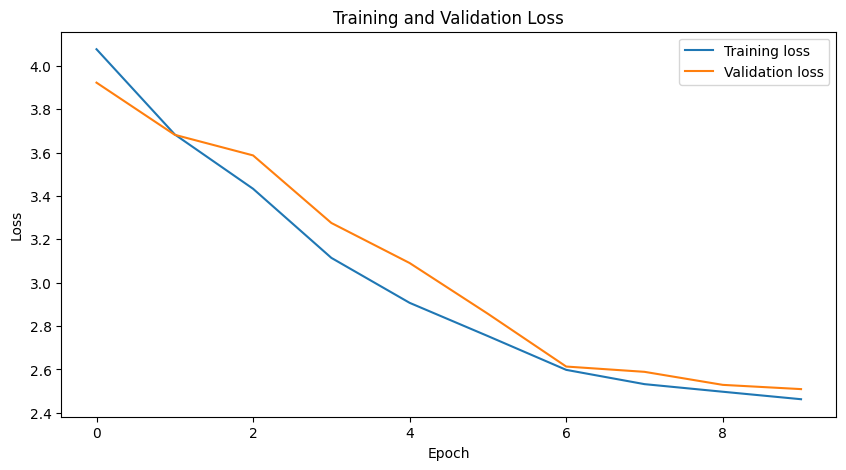

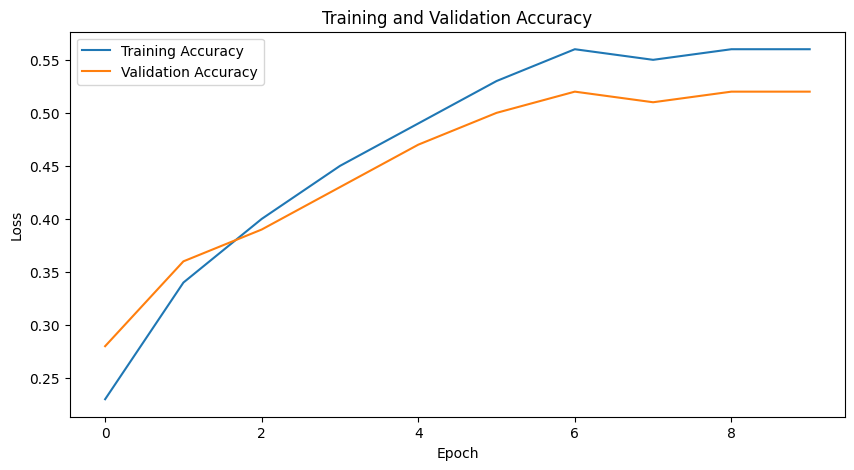

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained('t5-base')

references = []
predictions = []

# Assume that the model and val_dataloader are defined
model.eval()
for batch in val_dataloader:
    # Move batch to device
    batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

    with torch.no_grad():
        # Forward pass
        outputs = model.generate(input_ids=batch['input_ids'],
                                 attention_mask=batch['attention_mask'])
        # Decode the outputs and add to predictions
        predictions.extend([tokenizer.decode(output, skip_special_tokens=True) for output in outputs])
        # Decode the labels and add to references
        references.extend([tokenizer.decode(label, skip_special_tokens=True) for label in batch['labels']])

# Now calculate the BLEU score
bleu_score = 0
for reference, prediction in zip(references, predictions):
    # sentence_bleu expects lists of tokens
    reference = reference.split()
    prediction = prediction.split()
    bleu_score += sentence_bleu([reference], prediction)

# Average the BLEU scores
bleu_score /= len(references)




In [ ]:
print(f"BLEU score: {bleu_score:.4f}")

BLEU score: 0.52333334


In [ ]:
def generate_answer(question):
    model.eval()
    input_text = "question: " + question + " answer:"
    inputs = tokenizer.encode(input_text, return_tensors='pt').to(device)
    outputs = model.generate(inputs, max_length=128, num_beams=4, early_stopping=True)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

question = "What university is committed to providing a safe environment for the campus community?"
print(generate_answer(question))

san jose state university


In [ ]:
def generate_answer(question):
    model.eval()
    input_text = "question: " + question + " answer:"
    inputs = tokenizer.encode(input_text, return_tensors='pt').to(device)
    outputs = model.generate(inputs, max_length=128, num_beams=4, early_stopping=True)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

question = "How much does sjsu spend on research each year?"
print(generate_answer(question))

over $600 million


In [ ]:
def generate_answer(question):
    model.eval()
    input_text = "question: " + question + " answer:"
    inputs = tokenizer.encode(input_text, return_tensors='pt').to(device)
    outputs = model.generate(inputs, max_length=128, num_beams=4, early_stopping=True)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

question = "Which university provides the tools researchers need to thrive?"
print(generate_answer(question))

san jose state


In [ ]:
def generate_answer(question):
    model.eval()
    input_text = "question: " + question + " answer:"
    inputs = tokenizer.encode(input_text, return_tensors='pt').to(device)
    outputs = model.generate(inputs, max_length=128, num_beams=4, early_stopping=True)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

question = "What type of investors did the club merge with?"
print(generate_answer(question))

spartan


In [ ]:
def generate_answer(question):
    model.eval()
    input_text = "question: " + question + " answer:"
    inputs = tokenizer.encode(input_text, return_tensors='pt').to(device)
    outputs = model.generate(inputs, max_length=128, num_beams=4, early_stopping=True)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

question = "What is the zip code of sjsu's title ix office?"
print(generate_answer(question))

95192


In [ ]:
def generate_answer(question):
    model.eval()
    input_text = "question: " + question + " answer:"
    inputs = tokenizer.encode(input_text, return_tensors='pt').to(device)
    outputs = model.generate(inputs, max_length=128, num_beams=4, early_stopping=True)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

question = "What types of students can attend sjsu?"
print(generate_answer(question))

spartan


In [ ]:
def generate_answer(question):
    model.eval()
    input_text = "question: " + question + " answer:"
    inputs = tokenizer.encode(input_text, return_tensors='pt').to(device)
    outputs = model.generate(inputs, max_length=128, num_beams=4, early_stopping=True)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

question = "What is the email address for the office of the registrar?"
print(generate_answer(question))

registrar@sjsu.edu


In [ ]:
def generate_answer(question):
    model.eval()
    input_text = "question: " + question + " answer:"
    inputs = tokenizer.encode(input_text, return_tensors='pt').to(device)
    outputs = model.generate(inputs, max_length=128, num_beams=4, early_stopping=True)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

question = "Where can you find the latest vaccination and mask information?"
print(generate_answer(question))

the health advisories website


In [ ]:
def generate_answer(question):
    model.eval()
    input_text = "question: " + question + " answer:"
    inputs = tokenizer.encode(input_text, return_tensors='pt').to(device)
    outputs = model.generate(inputs, max_length=128, num_beams=4, early_stopping=True)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

question = "What is the website for san jose state university?"
print(generate_answer(question))

www.sjsu.edu
